In [1]:
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init': {'values': ['random', 'xavier']},
        'weight_decay': {"values": [0, 0.0005, 0.5]}
    },
    "run_cap": 10
}

# Load and preprocess the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
num_classes = 10

# Define class names for the Fashion-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Keep original labels for confusion matrix
y_train_original = y_train.copy()
y_test_original = y_test.copy()

y_train, y_test = one_hot_encode(y_train, num_classes), one_hot_encode(y_test, num_classes)

# Split training data into train and validation sets
split_idx = int(0.9 * len(x_train))
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]
y_train_original, y_val_original = y_train_original[:split_idx], y_train_original[split_idx:]

# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

activation_functions = {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}

# Optimizer functions
def sgd(weights, biases, grads_W, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_W[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def momentum(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        weights[i] += velocity_W[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def nesterov(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        # Compute lookahead position
        lookahead_W = weights[i] + momentum * velocity_W[i]
        lookahead_b = biases[i] + momentum * velocity_b[i]

        # Update velocity
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        # Update weights and biases with corrected lookahead step
        weights[i] = lookahead_W + velocity_W[i]
        biases[i] = lookahead_b + velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def rmsprop(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta=0.9, epsilon=1e-6):
    for i in range(len(weights)):
        # Update velocity for weights and biases separately
        velocity_W[i] = beta * velocity_W[i] + (1 - beta) * (grads_W[i] ** 2)
        velocity_b[i] = beta * velocity_b[i] + (1 - beta) * (grads_b[i] ** 2)

        # Update weights
        weights[i] -= learning_rate * grads_W[i] / (np.sqrt(velocity_W[i]) + epsilon)

        # Update biases
        biases[i] -= learning_rate * grads_b[i] / (np.sqrt(velocity_b[i]) + epsilon)
    return weights, biases, velocity_W, velocity_b

def adam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = velocity_W[i] / (1 - beta1 ** t)
        velocity_b_corrected = velocity_b[i] / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Check and correct shape mismatch
        if moment2_b_corrected.shape != biases[i].shape:
            print(f"Shape mismatch at layer {i}: {moment2_b_corrected.shape} vs {biases[i].shape}")
            moment2_b_corrected = np.reshape(moment2_b_corrected, biases[i].shape)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

def nadam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = (beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]) / (1 - beta1 ** t)
        velocity_b_corrected = (beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]) / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

# Initialize network weights and biases
def init_weights(layers, method="random"):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
        else:  # Default to "random"
            limit = 0.1
        W = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        weights.append(W)
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# Forward pass
def forward(X, weights, biases, activation):
    A = [X]
    for i in range(len(weights) - 1):
        Z = A[-1] @ weights[i] + biases[i]
        A.append(activation_functions[activation](Z))
    Z = A[-1] @ weights[-1] + biases[-1]
    A.append(softmax(Z))
    return A

# Compute loss
def compute_loss(y_true, y_pred, weights, weight_decay):
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    loss += (weight_decay / 2) * sum(np.sum(W**2) for W in weights)
    return loss

# Backward pass
def backward(X, y, A, weights, weight_decay, activation):
    grads_W, grads_b = [], []
    dA = A[-1] - y
    
    for i in reversed(range(len(weights))):
        dW = A[i].T @ dA / X.shape[0]
        db = np.sum(dA, axis=0, keepdims=True) / X.shape[0]
        dW += weight_decay * weights[i]
        grads_W.append(dW)
        grads_b.append(db)
        
        if i > 0:
            if activation == "relu":
                dA = (dA @ weights[i].T) * (A[i] > 0)
            elif activation == "sigmoid":
                dA = (dA @ weights[i].T) * (A[i] * (1 - A[i]))
            elif activation == "tanh":
                dA = (dA @ weights[i].T) * (1 - A[i]**2)
    
    return grads_W[::-1], grads_b[::-1]

# Get predictions from the model
def predict(X, weights, biases, activation):
    A = forward(X, weights, biases, activation)
    return np.argmax(A[-1], axis=1)

# Function to log confusion matrices at each epoch
def log_confusion_matrix_per_epoch(X, y_true, weights, biases, activation, dataset_name, epoch):
    # Get predictions
    predictions = predict(X, weights, biases, activation)
    
    # Log the confusion matrix
    wandb.log({
        f"{dataset_name}_confusion_matrix_epoch_{epoch}": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_true, 
            preds=predictions,
            class_names=class_names
        ),
        "epoch": epoch
    })

# Train function with per-epoch confusion matrix logging
def train(X_train, y_train, X_val, y_val, y_train_original, y_val_original, layers, learning_rate, activation, optimizer, 
          weight_init, weight_decay, epochs, batch_size, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-6):
    
    # Initialize weights and biases
    weights, biases = init_weights(layers, weight_init)
    
    # Initialize optimizer-specific parameters
    velocity_W = [np.zeros_like(W) for W in weights]
    velocity_b = [np.zeros_like(b) for b in biases]
    moment2_W = [np.zeros_like(W) for W in weights]
    moment2_b = [np.zeros_like(b) for b in biases]
    t = 1  # Timestep for Adam/Nadam
    
    num_samples = X_train.shape[0]
    
    # Keep track of best validation accuracy
    best_val_acc = 0
    best_weights, best_biases = None, None
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]
        y_train_original_shuffled = y_train_original[indices]
        
        total_loss, total_acc = 0, 0
        num_batches = num_samples // batch_size
        
        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            
            # Forward Pass
            A = forward(X_batch, weights, biases, activation)
            y_pred = A[-1]
            
            # Compute Loss & Accuracy
            loss = compute_loss(y_batch, y_pred, weights, weight_decay)
            acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
            
            total_loss += loss * len(X_batch)
            total_acc += acc * len(X_batch)
            
            # Backward Pass
            grads_W, grads_b = backward(X_batch, y_batch, A, weights, weight_decay, activation)
            
            # Update Weights using the selected optimizer
            if optimizer == "sgd":
                weights, biases = sgd(weights, biases, grads_W, grads_b, learning_rate)
            elif optimizer == "momentum":
                weights, biases, velocity_W, velocity_b = momentum(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "nesterov":
                weights, biases, velocity_W, velocity_b = nesterov(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "rmsprop":
                weights, biases, velocity_W, velocity_b = rmsprop(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta, epsilon)
            elif optimizer == "adam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = adam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
            elif optimizer == "nadam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = nadam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / num_samples
        avg_acc = total_acc / num_samples
        
        # Validation Metrics
        val_A = forward(X_val, weights, biases, activation)
        val_pred = val_A[-1]
        val_loss = compute_loss(y_val, val_pred, weights, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
        
        # Log confusion matrices for training and validation data at each epoch
        log_confusion_matrix_per_epoch(X_train, y_train_original, weights, biases, activation, "train", epoch+1)
        log_confusion_matrix_per_epoch(X_val, y_val_original, weights, biases, activation, "val", epoch+1)
        
        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1, 
            "loss": avg_loss, 
            "accuracy": avg_acc,
            "val_loss": val_loss, 
            "val_accuracy": val_acc
        })
        
        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
    
    # Return the best model weights and biases
    return best_weights, best_biases

# Function to run a single training job with wandb logging
def train_model():
    # Initialize wandb for this run
    wandb.init(project="assignment_1", entity="da24m015-iitm")
    config = wandb.config
    wandb.run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    
    # Create network architecture based on config
    architecture = [784] + [config.hidden_size] * config.hidden_layers + [10]
    
    # Train the network and get the best model
    best_weights, best_biases = train(
        x_train, y_train, x_val, y_val, y_train_original, y_val_original,
        layers=architecture,
        learning_rate=config.learning_rate,
        activation=config.activation,
        optimizer=config.optimizer,
        weight_init=config.weight_init,
        weight_decay=config.weight_decay,
        epochs=config.epochs,
        batch_size=config.batch_size
    )
    
    # Log the confusion matrices for the best model
    # For the TRAIN dataset
    train_predictions = predict(x_train, best_weights, best_biases, config.activation)
    wandb.log({
        "best_model_train_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_train_original,
            preds=train_predictions,
            class_names=class_names
        )
    })
    
    # For the TEST dataset
    test_predictions = predict(x_test, best_weights, best_biases, config.activation)
    wandb.log({
        "best_model_test_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test_original,
            preds=test_predictions,
            class_names=class_names
        )
    })
    
    # Calculate and log the test accuracy
    test_accuracy = np.mean(test_predictions == y_test_original)
    wandb.log({"best_model_test_accuracy": test_accuracy})
    
    # Log confusion matrices for validation set as well (for completeness)
    val_predictions = predict(x_val, best_weights, best_biases, config.activation)
    wandb.log({
        "best_model_val_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_val_original,
            preds=val_predictions,
            class_names=class_names
        )
    })

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="assignment_1")

# Run the sweep
wandb.agent(sweep_id, function=train_model)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: s3a26pnx
Sweep URL: https://wandb.ai/da24m015-iitm/assignment_1/sweeps/s3a26pnx


wandb: Agent Starting Run: qwetvhy7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
wandb: Currently logged in as: da24m015 (da24m015-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


accuracy,▁▆▇██
best_model_test_accuracy,▁
epoch,▁▁▁▃▃▃▅▅▅▆▆▆███
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
accuracy,0.86435
best_model_test_accuracy,0.8583
epoch,5
loss,0.44564
val_accuracy,0.86367


wandb: Agent Starting Run: o9tgh30b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


accuracy,▁▁▂▂▂▃▄▅▆█
best_model_test_accuracy,▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
loss,█▇▇▆▅▄▄▃▂▁
val_accuracy,▁▁▂▂▂▃▄▅▇█
val_loss,█▇▇▆▅▄▄▃▂▁
accuracy,0.23969
best_model_test_accuracy,0.2557
epoch,10
loss,2.29608
val_accuracy,0.263


wandb: Agent Starting Run: ye9b17fq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


accuracy,▁▅▆▇▇▇▇███
best_model_test_accuracy,▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇█▇▇▇██
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.89431
best_model_test_accuracy,0.8724
epoch,10
loss,0.42077
val_accuracy,0.8825


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# not printing the confusion matrix
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init': {'values': ['random', 'xavier']},
        'weight_decay': {"values": [0, 0.0005, 0.5]}
    },
    "run_cap": 10
}

# Load and preprocess the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
num_classes = 10

# Define class names for the Fashion-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Keep original labels for confusion matrix
y_train_original = y_train.copy()
y_test_original = y_test.copy()

y_train, y_test = one_hot_encode(y_train, num_classes), one_hot_encode(y_test, num_classes)

# Split training data into train and validation sets
split_idx = int(0.9 * len(x_train))
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]
y_train_original, y_val_original = y_train_original[:split_idx], y_train_original[split_idx:]

# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

activation_functions = {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}

# Optimizer functions
def sgd(weights, biases, grads_W, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_W[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def momentum(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        weights[i] += velocity_W[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def nesterov(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        # Compute lookahead position
        lookahead_W = weights[i] + momentum * velocity_W[i]
        lookahead_b = biases[i] + momentum * velocity_b[i]

        # Update velocity
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        # Update weights and biases with corrected lookahead step
        weights[i] = lookahead_W + velocity_W[i]
        biases[i] = lookahead_b + velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def rmsprop(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta=0.9, epsilon=1e-6):
    for i in range(len(weights)):
        # Update velocity for weights and biases separately
        velocity_W[i] = beta * velocity_W[i] + (1 - beta) * (grads_W[i] ** 2)
        velocity_b[i] = beta * velocity_b[i] + (1 - beta) * (grads_b[i] ** 2)

        # Update weights
        weights[i] -= learning_rate * grads_W[i] / (np.sqrt(velocity_W[i]) + epsilon)

        # Update biases
        biases[i] -= learning_rate * grads_b[i] / (np.sqrt(velocity_b[i]) + epsilon)
    return weights, biases, velocity_W, velocity_b

def adam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = velocity_W[i] / (1 - beta1 ** t)
        velocity_b_corrected = velocity_b[i] / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Check and correct shape mismatch
        if moment2_b_corrected.shape != biases[i].shape:
            print(f"Shape mismatch at layer {i}: {moment2_b_corrected.shape} vs {biases[i].shape}")
            moment2_b_corrected = np.reshape(moment2_b_corrected, biases[i].shape)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

def nadam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = (beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]) / (1 - beta1 ** t)
        velocity_b_corrected = (beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]) / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

# Initialize network weights and biases
def init_weights(layers, method="random"):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
        else:  # Default to "random"
            limit = 0.1
        W = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        weights.append(W)
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# Forward pass
def forward(X, weights, biases, activation):
    A = [X]
    for i in range(len(weights) - 1):
        Z = A[-1] @ weights[i] + biases[i]
        A.append(activation_functions[activation](Z))
    Z = A[-1] @ weights[-1] + biases[-1]
    A.append(softmax(Z))
    return A

# Compute loss
def compute_loss(y_true, y_pred, weights, weight_decay):
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    loss += (weight_decay / 2) * sum(np.sum(W**2) for W in weights)
    return loss

# Backward pass
def backward(X, y, A, weights, weight_decay, activation):
    grads_W, grads_b = [], []
    dA = A[-1] - y
    
    for i in reversed(range(len(weights))):
        dW = A[i].T @ dA / X.shape[0]
        db = np.sum(dA, axis=0, keepdims=True) / X.shape[0]
        dW += weight_decay * weights[i]
        grads_W.append(dW)
        grads_b.append(db)
        
        if i > 0:
            if activation == "relu":
                dA = (dA @ weights[i].T) * (A[i] > 0)
            elif activation == "sigmoid":
                dA = (dA @ weights[i].T) * (A[i] * (1 - A[i]))
            elif activation == "tanh":
                dA = (dA @ weights[i].T) * (1 - A[i]**2)
    
    return grads_W[::-1], grads_b[::-1]

# Get predictions from the model
def predict(X, weights, biases, activation):
    A = forward(X, weights, biases, activation)
    return np.argmax(A[-1], axis=1)

# Function to log confusion matrices at each epoch
def log_confusion_matrix_per_epoch(X, y_true, weights, biases, activation, dataset_name, epoch):
    # Get predictions
    predictions = predict(X, weights, biases, activation)
    
    # Log the confusion matrix
    wandb.log({
        f"{dataset_name}_confusion_matrix_epoch_{epoch}": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_true, 
            preds=predictions,
            class_names=class_names
        ),
        "epoch": epoch
    })

# Train function with per-epoch confusion matrix logging
def train(X_train, y_train, X_val, y_val, y_train_original, y_val_original, layers, learning_rate, activation, optimizer, 
          weight_init, weight_decay, epochs, batch_size, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-6):
    
    # Initialize weights and biases
    weights, biases = init_weights(layers, weight_init)
    
    # Initialize optimizer-specific parameters
    velocity_W = [np.zeros_like(W) for W in weights]
    velocity_b = [np.zeros_like(b) for b in biases]
    moment2_W = [np.zeros_like(W) for W in weights]
    moment2_b = [np.zeros_like(b) for b in biases]
    t = 1  # Timestep for Adam/Nadam
    
    num_samples = X_train.shape[0]
    
    # Keep track of best validation accuracy
    best_val_acc = 0
    best_weights, best_biases = None, None
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]
        y_train_original_shuffled = y_train_original[indices]
        
        total_loss, total_acc = 0, 0
        num_batches = num_samples // batch_size
        
        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            
            # Forward Pass
            A = forward(X_batch, weights, biases, activation)
            y_pred = A[-1]
            
            # Compute Loss & Accuracy
            loss = compute_loss(y_batch, y_pred, weights, weight_decay)
            acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
            
            total_loss += loss * len(X_batch)
            total_acc += acc * len(X_batch)
            
            # Backward Pass
            grads_W, grads_b = backward(X_batch, y_batch, A, weights, weight_decay, activation)
            
            # Update Weights using the selected optimizer
            if optimizer == "sgd":
                weights, biases = sgd(weights, biases, grads_W, grads_b, learning_rate)
            elif optimizer == "momentum":
                weights, biases, velocity_W, velocity_b = momentum(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "nesterov":
                weights, biases, velocity_W, velocity_b = nesterov(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "rmsprop":
                weights, biases, velocity_W, velocity_b = rmsprop(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta, epsilon)
            elif optimizer == "adam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = adam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
            elif optimizer == "nadam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = nadam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / num_samples
        avg_acc = total_acc / num_samples
        
        # Validation Metrics
        val_A = forward(X_val, weights, biases, activation)
        val_pred = val_A[-1]
        val_loss = compute_loss(y_val, val_pred, weights, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
        
        # Log confusion matrices for training and validation data at each epoch
        log_confusion_matrix_per_epoch(X_train, y_train_original, weights, biases, activation, "train", epoch+1)
        log_confusion_matrix_per_epoch(X_val, y_val_original, weights, biases, activation, "val", epoch+1)
        
        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1, 
            "loss": avg_loss, 
            "accuracy": avg_acc,
            "val_loss": val_loss, 
            "val_accuracy": val_acc
        })
        
        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
    
    # Return the best model weights and biases
    return best_weights, best_biases

# Function to run a single training job with wandb logging
def train_model():
    # Initialize wandb for this run
    wandb.init(project="assignment_1", entity="da24m015-iitm")
    config = wandb.config
    wandb.run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    
    # Create network architecture based on config
    architecture = [784] + [config.hidden_size] * config.hidden_layers + [10]
    
    # Train the network and get the best model
    best_weights, best_biases = train(
        x_train, y_train, x_val, y_val, y_train_original, y_val_original,
        layers=architecture,
        learning_rate=config.learning_rate,
        activation=config.activation,
        optimizer=config.optimizer,
        weight_init=config.weight_init,
        weight_decay=config.weight_decay,
        epochs=config.epochs,
        batch_size=config.batch_size
    )
    
    # Log final test confusion matrix
    log_confusion_matrix_per_epoch(x_test, y_test_original, best_weights, best_biases, config.activation, "test", config.epochs)

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="assignment_1")

# Run the sweep
wandb.agent(sweep_id, function=train_model)

Create sweep with ID: lx7gbvwf
Sweep URL: https://wandb.ai/da24m015-iitm/assignment_1/sweeps/lx7gbvwf


wandb: Agent Starting Run: okra7oeu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


In [ ]:
# log the confusion matrix (till question 7)
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init': {'values': ['random', 'xavier']},
        'weight_decay': {"values": [0, 0.0005, 0.5]}
    },
    "run_cap": 5
}

# Load and preprocess the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
num_classes = 10

# Define class names for the Fashion-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Keep original labels for confusion matrix
y_train_original = y_train.copy()
y_test_original = y_test.copy()

y_train, y_test = one_hot_encode(y_train, num_classes), one_hot_encode(y_test, num_classes)

# Split training data into train and validation sets
split_idx = int(0.9 * len(x_train))
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]
y_train_original, y_val_original = y_train_original[:split_idx], y_train_original[split_idx:]

# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

activation_functions = {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}

# Optimizer functions
def sgd(weights, biases, grads_W, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_W[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def momentum(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        weights[i] += velocity_W[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def nesterov(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        # Compute lookahead position
        lookahead_W = weights[i] + momentum * velocity_W[i]
        lookahead_b = biases[i] + momentum * velocity_b[i]

        # Update velocity
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        # Update weights and biases with corrected lookahead step
        weights[i] = lookahead_W + velocity_W[i]
        biases[i] = lookahead_b + velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def rmsprop(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta=0.9, epsilon=1e-6):
    for i in range(len(weights)):
        # Update velocity for weights and biases separately
        velocity_W[i] = beta * velocity_W[i] + (1 - beta) * (grads_W[i] ** 2)
        velocity_b[i] = beta * velocity_b[i] + (1 - beta) * (grads_b[i] ** 2)

        # Update weights
        weights[i] -= learning_rate * grads_W[i] / (np.sqrt(velocity_W[i]) + epsilon)

        # Update biases
        biases[i] -= learning_rate * grads_b[i] / (np.sqrt(velocity_b[i]) + epsilon)
    return weights, biases, velocity_W, velocity_b

def adam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = velocity_W[i] / (1 - beta1 ** t)
        velocity_b_corrected = velocity_b[i] / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Check and correct shape mismatch
        if moment2_b_corrected.shape != biases[i].shape:
            print(f"Shape mismatch at layer {i}: {moment2_b_corrected.shape} vs {biases[i].shape}")
            moment2_b_corrected = np.reshape(moment2_b_corrected, biases[i].shape)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

def nadam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = (beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]) / (1 - beta1 ** t)
        velocity_b_corrected = (beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]) / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

# Initialize network weights and biases
def init_weights(layers, method="random"):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
        else:  # Default to "random"
            limit = 0.1
        W = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        weights.append(W)
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# Forward pass
def forward(X, weights, biases, activation):
    A = [X]
    for i in range(len(weights) - 1):
        Z = A[-1] @ weights[i] + biases[i]
        A.append(activation_functions[activation](Z))
    Z = A[-1] @ weights[-1] + biases[-1]
    A.append(softmax(Z))
    return A

# Compute loss
def compute_loss(y_true, y_pred, weights, weight_decay):
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    loss += (weight_decay / 2) * sum(np.sum(W**2) for W in weights)
    return loss

# Backward pass
def backward(X, y, A, weights, weight_decay, activation):
    grads_W, grads_b = [], []
    dA = A[-1] - y
    
    for i in reversed(range(len(weights))):
        dW = A[i].T @ dA / X.shape[0]
        db = np.sum(dA, axis=0, keepdims=True) / X.shape[0]
        dW += weight_decay * weights[i]
        grads_W.append(dW)
        grads_b.append(db)
        
        if i > 0:
            if activation == "relu":
                dA = (dA @ weights[i].T) * (A[i] > 0)
            elif activation == "sigmoid":
                dA = (dA @ weights[i].T) * (A[i] * (1 - A[i]))
            elif activation == "tanh":
                dA = (dA @ weights[i].T) * (1 - A[i]**2)
    
    return grads_W[::-1], grads_b[::-1]

# Get predictions from the model
def predict(X, weights, biases, activation):
    A = forward(X, weights, biases, activation)
    return np.argmax(A[-1], axis=1)

# Train function
def train(X_train, y_train, X_val, y_val, y_train_original, y_val_original, layers, learning_rate, activation, optimizer, 
          weight_init, weight_decay, epochs, batch_size, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-6):
    
    # Initialize weights and biases
    weights, biases = init_weights(layers, weight_init)
    
    # Initialize optimizer-specific parameters
    velocity_W = [np.zeros_like(W) for W in weights]
    velocity_b = [np.zeros_like(b) for b in biases]
    moment2_W = [np.zeros_like(W) for W in weights]
    moment2_b = [np.zeros_like(b) for b in biases]
    t = 1  # Timestep for Adam/Nadam
    
    num_samples = X_train.shape[0]
    
    # Keep track of best validation accuracy
    best_val_acc = 0
    best_weights, best_biases = None, None
    
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]
        y_train_original_shuffled = y_train_original[indices]
        
        total_loss, total_acc = 0, 0
        num_batches = num_samples // batch_size
        
        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            
            # Forward Pass
            A = forward(X_batch, weights, biases, activation)
            y_pred = A[-1]
            
            # Compute Loss & Accuracy
            loss = compute_loss(y_batch, y_pred, weights, weight_decay)
            acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
            
            total_loss += loss * len(X_batch)
            total_acc += acc * len(X_batch)
            
            # Backward Pass
            grads_W, grads_b = backward(X_batch, y_batch, A, weights, weight_decay, activation)
            
            # Update Weights using the selected optimizer
            if optimizer == "sgd":
                weights, biases = sgd(weights, biases, grads_W, grads_b, learning_rate)
            elif optimizer == "momentum":
                weights, biases, velocity_W, velocity_b = momentum(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "nesterov":
                weights, biases, velocity_W, velocity_b = nesterov(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b)
            elif optimizer == "rmsprop":
                weights, biases, velocity_W, velocity_b = rmsprop(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta, epsilon)
            elif optimizer == "adam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = adam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
            elif optimizer == "nadam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = nadam(
                    weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t, beta1, beta2, epsilon)
                t += 1
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / num_samples
        avg_acc = total_acc / num_samples
        
        # Validation Metrics
        val_A = forward(X_val, weights, biases, activation)
        val_pred = val_A[-1]
        val_loss = compute_loss(y_val, val_pred, weights, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
        
        # Log to Weights & Biases
        wandb.log({
            "epoch": epoch + 1, 
            "loss": avg_loss, 
            "accuracy": avg_acc,
            "val_loss": val_loss, 
            "val_accuracy": val_acc
        })
        
        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
    
    # Return the best model weights and biases
    return best_weights, best_biases

# Function to create and log confusion matrices
def log_confusion_matrices(weights, biases, activation):
    # Get predictions for training data
    train_predictions = predict(x_train, weights, biases, activation)
    
    # Get predictions for test data
    test_predictions = predict(x_test, weights, biases, activation)
    
    # Log the training confusion matrix
    wandb.log({
        "train_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_train_original, 
            preds=train_predictions,
            class_names=class_names
        )
    })
    
    # Log the test confusion matrix
    wandb.log({
        "test_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test_original, 
            preds=test_predictions,
            class_names=class_names
        )
    })

# Function to run a single training job with wandb logging
def train_model():
    # Initialize wandb for this run
    wandb.init(project="assignment_1", entity="da24m015-iitm")
    config = wandb.config
    wandb.run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    
    # Create network architecture based on config
    architecture = [784] + [config.hidden_size] * config.hidden_layers + [10]
    
    # Train the network and get the best model
    best_weights, best_biases = train(
        x_train, y_train, x_val, y_val, y_train_original, y_val_original,
        layers=architecture,
        learning_rate=config.learning_rate,
        activation=config.activation,
        optimizer=config.optimizer,
        weight_init=config.weight_init,
        weight_decay=config.weight_decay,
        epochs=config.epochs,
        batch_size=config.batch_size
    )
    print(f"Best_weights:{best_weights},Best_biases:{best_biases}")
    # Log confusion matrices for the best model
    log_confusion_matrices(best_weights, best_biases, config.activation)

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="assignment_1")

# Run the sweep
wandb.agent(sweep_id, function=train_model)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 0t4kxske
Sweep URL: https://wandb.ai/da24m015-iitm/assignment_1/sweeps/0t4kxske


wandb: Agent Starting Run: q08420bc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random
wandb: Currently logged in as: da24m015 (da24m015-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Best_weights:[array([[-0.05216659,  0.08270878,  0.03424146, ..., -0.05701827,
         0.02512718,  0.02028427],
       [-0.08653061,  0.01632067, -0.08762236, ...,  0.07152038,
        -0.01927711,  0.07835504],
       [-0.0117141 , -0.02355968, -0.02705998, ..., -0.08495119,
         0.00554691,  0.04150443],
       ...,
       [ 0.09507752,  0.07022542,  0.06338356, ..., -0.0729068 ,
         0.04327816,  0.03189479],
       [-0.05825874, -0.01498061,  0.0757699 , ...,  0.07003182,
        -0.00849934,  0.07575871],
       [-0.00014141, -0.03266108, -0.04543727, ..., -0.0056526 ,
        -0.04470036,  0.02271949]]), array([[-0.0023959 , -0.09006189, -0.02136422, ..., -0.04316662,
         0.01400784,  0.03983845],
       [ 0.02164511, -0.00310404, -0.0551893 , ...,  0.09742472,
        -0.05402902, -0.00297696],
       [ 0.02413507,  0.03307944,  0.01728318, ...,  0.0236859 ,
        -0.01415782, -0.06944164],
       ...,
       [ 0.07210727,  0.03792157,  0.0323013 , ...,  0.09656

accuracy,▂▇▁██
epoch,▁▃▅▆█
loss,█▂▃▁▁
val_accuracy,██▄█▁
val_loss,▁▅▅▆█
accuracy,0.10076
epoch,5
loss,2.30309
val_accuracy,0.0925
val_loss,2.30353


wandb: Agent Starting Run: mcbi60ou with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json

# Define the sweep configuration with fixed 3 epochs
sweep_config = {
    'method': 'random',
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'value': 3},  # Fixed to 3 epochs
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init': {'values': ['random', 'xavier']},
        'weight_decay': {"values": [0, 0.0005, 0.5]}
    },
    "run_cap": 3
}

# Load and preprocess the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
num_classes = 10

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

y_train_encoded, y_test_encoded = one_hot_encode(y_train, num_classes), one_hot_encode(y_test, num_classes)

# Save original labels for confusion matrix
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

# Split training data into train and validation sets
split_idx = int(0.9 * len(x_train))
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train_encoded, y_val_encoded = y_train_encoded[:split_idx], y_train_encoded[split_idx:]
y_train_labels = y_train_labels[:split_idx]

# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

activation_functions = {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}

# Optimizer functions
def sgd(weights, biases, grads_W, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_W[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def momentum(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        weights[i] += velocity_W[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def nesterov(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        # Compute lookahead position
        lookahead_W = weights[i] + momentum * velocity_W[i]
        lookahead_b = biases[i] + momentum * velocity_b[i]

        # Update velocity
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        # Update weights and biases with corrected lookahead step
        weights[i] = lookahead_W + velocity_W[i]
        biases[i] = lookahead_b + velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def rmsprop(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta=0.9, epsilon=1e-6):
    for i in range(len(weights)):
        # Update velocity for weights and biases separately
        velocity_W[i] = beta * velocity_W[i] + (1 - beta) * (grads_W[i] ** 2)
        velocity_b[i] = beta * velocity_b[i] + (1 - beta) * (grads_b[i] ** 2)

        # Update weights
        weights[i] -= learning_rate * grads_W[i] / (np.sqrt(velocity_W[i]) + epsilon)

        # Update biases
        biases[i] -= learning_rate * grads_b[i] / (np.sqrt(velocity_b[i]) + epsilon)
    return weights, biases, velocity_W, velocity_b

def adam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = velocity_W[i] / (1 - beta1 ** t)
        velocity_b_corrected = velocity_b[i] / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Check and correct shape mismatch
        if moment2_b_corrected.shape != biases[i].shape:
            print(f"Shape mismatch at layer {i}: {moment2_b_corrected.shape} vs {biases[i].shape}")
            moment2_b_corrected = np.reshape(moment2_b_corrected, biases[i].shape)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

def nadam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = (beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]) / (1 - beta1 ** t)
        velocity_b_corrected = (beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]) / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

# Initialize network weights and biases
def init_weights(layers, method="random"):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
        else:  # Default to "random"
            limit = 0.1
        W = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        weights.append(W)
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# Forward pass
def forward(X, weights, biases, activation):
    A = [X]
    for i in range(len(weights) - 1):
        Z = A[-1] @ weights[i] + biases[i]
        A.append(activation_functions[activation](Z))
    Z = A[-1] @ weights[-1] + biases[-1]
    A.append(softmax(Z))
    return A

# Compute loss
def compute_loss(y_true, y_pred, weights, weight_decay):
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    loss += (weight_decay / 2) * sum(np.sum(W**2) for W in weights)
    return loss

# Backward pass
def backward(X, y, A, weights, weight_decay, activation):
    grads_W, grads_b = [], []
    dA = A[-1] - y
    
    for i in reversed(range(len(weights))):
        dW = A[i].T @ dA / X.shape[0]
        db = np.sum(dA, axis=0, keepdims=True) / X.shape[0]
        dW += weight_decay * weights[i]
        grads_W.append(dW)
        grads_b.append(db)
        
        if i > 0:
            if activation == "relu":
                dA = (dA @ weights[i].T) * (A[i] > 0)
            elif activation == "sigmoid":
                dA = (dA @ weights[i].T) * (A[i] * (1 - A[i]))
            elif activation == "tanh":
                dA = (dA @ weights[i].T) * (1 - A[i]**2)
    
    return grads_W[::-1], grads_b[::-1]

# Function to evaluate a model and get predictions
def evaluate_model(weights, biases, X, y_encoded, y_labels, activation):
    # Forward pass
    A = forward(X, weights, biases, activation)
    y_pred = A[-1]
    
    # Calculate accuracy
    y_pred_labels = np.argmax(y_pred, axis=1)
    acc = np.mean(y_pred_labels == y_labels)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_labels, y_pred_labels)
    
    return acc, cm, y_pred_labels

# Function to plot confusion matrix with enhanced visualization
def plot_confusion_matrix(cm, class_names, dataset_type):
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap with a custom colormap
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
    
    # Improve aesthetics
    plt.title(f'Confusion Matrix for Fashion MNIST {dataset_type} Set', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    # Save the confusion matrix
    filename = f'confusion_matrix_{dataset_type.lower()}.png'
    plt.tight_layout()
    plt.savefig(filename)
    
    # Log to wandb
    wandb.log({f"confusion_matrix_{dataset_type.lower()}": wandb.Image(plt)})
    
    plt.close()

# Function to plot misclassified examples
def plot_misclassifications(X, y_true, y_pred, class_names, dataset_type):
    # Find misclassified examples
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) > 0:
        # Select a subset of misclassified examples
        sample_size = min(25, len(misclassified_indices))
        sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
        
        # Create a grid to display the images
        fig, axes = plt.subplots(5, 5, figsize=(15, 15))
        axes = axes.flatten()
        
        # Original shape of each image
        img_size = int(np.sqrt(X.shape[1]))
        
        for i, idx in enumerate(sample_indices):
            if i < 25:  # Ensure we don't go out of bounds
                # Reshape the flattened image back to 2D
                img = X[idx].reshape(img_size, img_size)
                
                # Display the image
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
                axes[i].axis('off')
        
        # Remove empty subplots
        for i in range(sample_size, 25):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        filename = f'misclassified_examples_{dataset_type.lower()}.png'
        plt.savefig(filename)
        
        # Log to wandb
        wandb.log({f"misclassified_examples_{dataset_type.lower()}": wandb.Image(plt)})
        
        plt.close()

# Modified train_model function to log confusion matrices during training
def train_model():
    # Initialize wandb for this run
    wandb.init(project="assignment_1", entity="da24m015-iitm")
    config = wandb.config
    wandb.run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_ep_{config.epochs}"
    
    # Create network architecture based on config
    architecture = [784] + [config.hidden_size] * config.hidden_layers + [10]
    
    # Initialize weights and biases
    weights, biases = init_weights(architecture, config.weight_init)
    
    # Initialize optimizer-specific parameters
    velocity_W = [np.zeros_like(W) for W in weights]
    velocity_b = [np.zeros_like(b) for b in biases]
    moment2_W = [np.zeros_like(W) for W in weights]
    moment2_b = [np.zeros_like(b) for b in biases]
    t = 1  # Timestep for Adam/Nadam
    
    num_samples = x_train.shape[0]
    
    best_val_acc = 0
    best_weights = None
    best_biases = None
    
    # Class names for Fashion MNIST
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    
    for epoch in range(config.epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = x_train[indices]
        y_train_encoded_shuffled = y_train_encoded[indices]
        y_train_labels_shuffled = y_train_labels[indices]
        
        total_loss, total_acc = 0, 0
        num_batches = num_samples // config.batch_size
        
        for i in range(0, num_samples, config.batch_size):
            X_batch = X_train_shuffled[i:i + config.batch_size]
            y_batch_encoded = y_train_encoded_shuffled[i:i + config.batch_size]
            
            # Forward Pass
            A = forward(X_batch, weights, biases, config.activation)
            y_pred = A[-1]
            
            # Compute Loss & Accuracy
            loss = compute_loss(y_batch_encoded, y_pred, weights, config.weight_decay)
            acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch_encoded, axis=1))
            
            total_loss += loss * len(X_batch)
            total_acc += acc * len(X_batch)
            
            # Backward Pass
            grads_W, grads_b = backward(X_batch, y_batch_encoded, A, weights, config.weight_decay, config.activation)
            
            # Update Weights using the selected optimizer
            if config.optimizer == "sgd":
                weights, biases = sgd(weights, biases, grads_W, grads_b, config.learning_rate)
            elif config.optimizer == "momentum":
                weights, biases, velocity_W, velocity_b = momentum(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "nesterov":
                weights, biases, velocity_W, velocity_b = nesterov(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "rmsprop":
                weights, biases, velocity_W, velocity_b = rmsprop(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "adam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = adam(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t)
                t += 1
            elif config.optimizer == "nadam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = nadam(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t)
                t += 1
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / num_samples
        avg_acc = total_acc / num_samples
        
        # Validation Metrics
        val_A = forward(x_val, weights, biases, config.activation)
        val_pred = val_A[-1]
        val_loss = compute_loss(y_val_encoded, val_pred, weights, config.weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val_encoded, axis=1))
        
        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1, 
            "loss": avg_loss, 
            "accuracy": avg_acc,
            "val_loss": val_loss, 
            "val_accuracy": val_acc
        })
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
    
    # After training, evaluate and log confusion matrices for train and test sets with best model
    train_acc, train_cm, train_pred = evaluate_model(
        best_weights, best_biases, x_train, y_train_encoded, y_train_labels, config.activation
    )
    
    test_acc, test_cm, test_pred = evaluate_model(
        best_weights, best_biases, x_test, y_test_encoded, y_test_labels, config.activation
    )
    
    # Log the confusion matrices
    plot_confusion_matrix(train_cm, class_names, "Training")
    plot_confusion_matrix(test_cm, class_names, "Test")
    
    # Plot misclassified examples
    plot_misclassifications(x_train, y_train_labels, train_pred, class_names, "Training")
    plot_misclassifications(x_test, y_test_labels, test_pred, class_names, "Test")
    
    # Log final test and train accuracy
    wandb.log({
        "final_train_accuracy": train_acc,
        "final_test_accuracy": test_acc
    })
    
    # Save the best model parameters to wandb
    model_artifact = wandb.Artifact('best_model', type='model')
    
    # Save the best model configuration for later retrieval
    best_config = {
        "architecture": architecture,
        "activation": config.activation,
        "optimizer": config.optimizer,
        "learning_rate": config.learning_rate,
        "batch_size": config.batch_size,
        "weight_decay": config.weight_decay,
        "weight_init": config.weight_init,
        "hidden_layers": config.hidden_layers,
        "hidden_size": config.hidden_size,
        "val_accuracy": best_val_acc,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc
    }
    
    # Save best model config as JSON
    with open('best_model_config.json', 'w') as f:
        json.dump(best_config, f)
    
    model_artifact.add_file('best_model_config.json')
    
    # Save best weights and biases as numpy arrays
    for i, (w, b) in enumerate(zip(best_weights, best_biases)):
        np.save(f'best_weights_{i}.npy', w)
        np.save(f'best_biases_{i}.npy', b)
        model_artifact.add_file(f'best_weights_{i}.npy')
        model_artifact.add_file(f'best_biases_{i}.npy')
    
    wandb.log_artifact(model_artifact)
    
    return best_weights, best_biases, best_config

# Main execution
if __name__ == "__main__":
    # Run the sweep with fixed 3 epochs
    sweep_id = wandb.sweep(sweep_config, project="assignment_1")
    wandb.agent(sweep_id, function=train_model)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001885F24D990>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1887d4f79d0, raw_cell="import numpy as np
import matplotlib.pyplot as plt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Rajnish/Desktop/Rajnish/M.Tech%20DSAI%2726/M.Tech%20DSAI%202024-2026/Semester%202/Introduction%20to%20Deep%20Learning/Introduction-to-Deep-Learning-DA6401-/Assignment%201/sample.ipynb#W6sZmlsZQ%3D%3D>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: uopjmcei
Sweep URL: https://wandb.ai/da24m015-iitm/assignment_1/sweeps/uopjmcei


wandb: Agent Starting Run: szq6ky86 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 3
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Exception in thread Thread-38 (_run_job):
Traceback (most recent call last):
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Rajnish\AppData\Local\Temp\ipykernel_16604\920114889.py", line 297, in train_model
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1485, in init
    wandb._sentry.reraise(e)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\analytics\sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1471, in init
    return wi.init(run_settings, run_config)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 779, in init
    with telemetry.context() as tel:
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wand

Exception in thread Thread-41 (_run_job):
Traceback (most recent call last):
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Rajnish\AppData\Local\Temp\ipykernel_16604\920114889.py", line 297, in train_model
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1485, in init
    wandb._sentry.reraise(e)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\analytics\sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1471, in init
    return wi.init(run_settings, run_config)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 779, in init
    with telemetry.context() as tel:
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wand

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001885F24D990>> (for post_run_cell), with arguments args (<ExecutionResult object at 1887d4f7d60, execution_count=3 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1887d4f79d0, raw_cell="import numpy as np
import matplotlib.pyplot as plt.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Rajnish/Desktop/Rajnish/M.Tech%20DSAI%2726/M.Tech%20DSAI%202024-2026/Semester%202/Introduction%20to%20Deep%20Learning/Introduction-to-Deep-Learning-DA6401-/Assignment%201/sample.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 79d02iaz
Sweep URL: https://wandb.ai/da24m015-iitm/assignment_1/sweeps/79d02iaz


wandb: Agent Starting Run: qr1qg8gw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
wandb: Currently logged in as: da24m015 (da24m015-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▃▂▆▄▇█▆█
val_loss,█▄▄▅▂▅▂▁▃▁
accuracy,0.75928
epoch,10
loss,0.88313
val_accuracy,0.763
val_loss,0.8665


wandb: Agent Starting Run: awbi2rzf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


accuracy,▆▁█▇▅
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▄██▁▁
val_loss,▃▁▄▅█
accuracy,0.09954
epoch,5
loss,2.30373
val_accuracy,0.09733
val_loss,2.30479


wandb: Agent Starting Run: 10z7a42s with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


accuracy,▅▄▁█▂
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,█▇▅▃▁
val_loss,▁▃▂█▃
accuracy,0.09841
epoch,5
loss,2.30297
val_accuracy,0.09417
val_loss,2.303


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Best run: amber-sweep-9 with validation accuracy: 0.8857


wandb:   13 of 13 files downloaded.  


Test accuracy: 0.1000


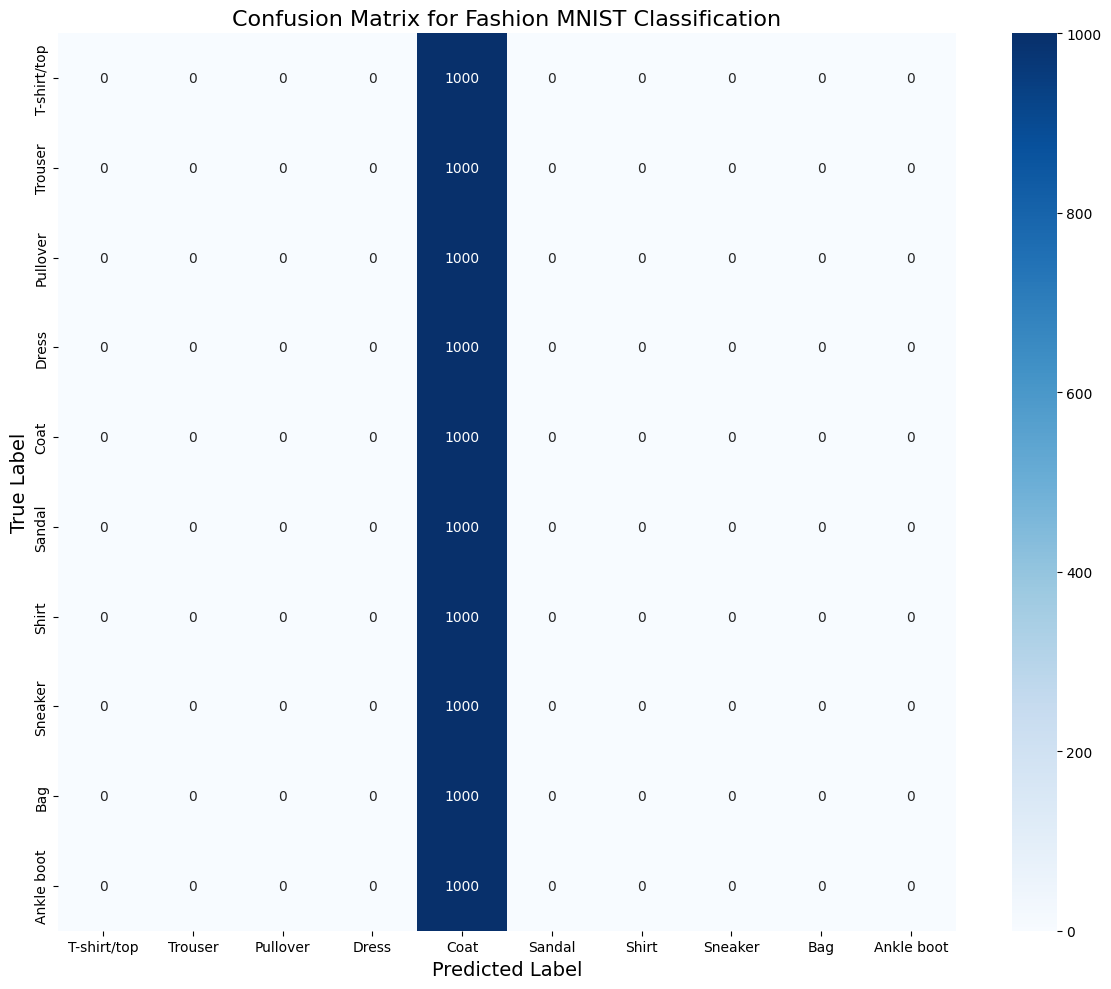

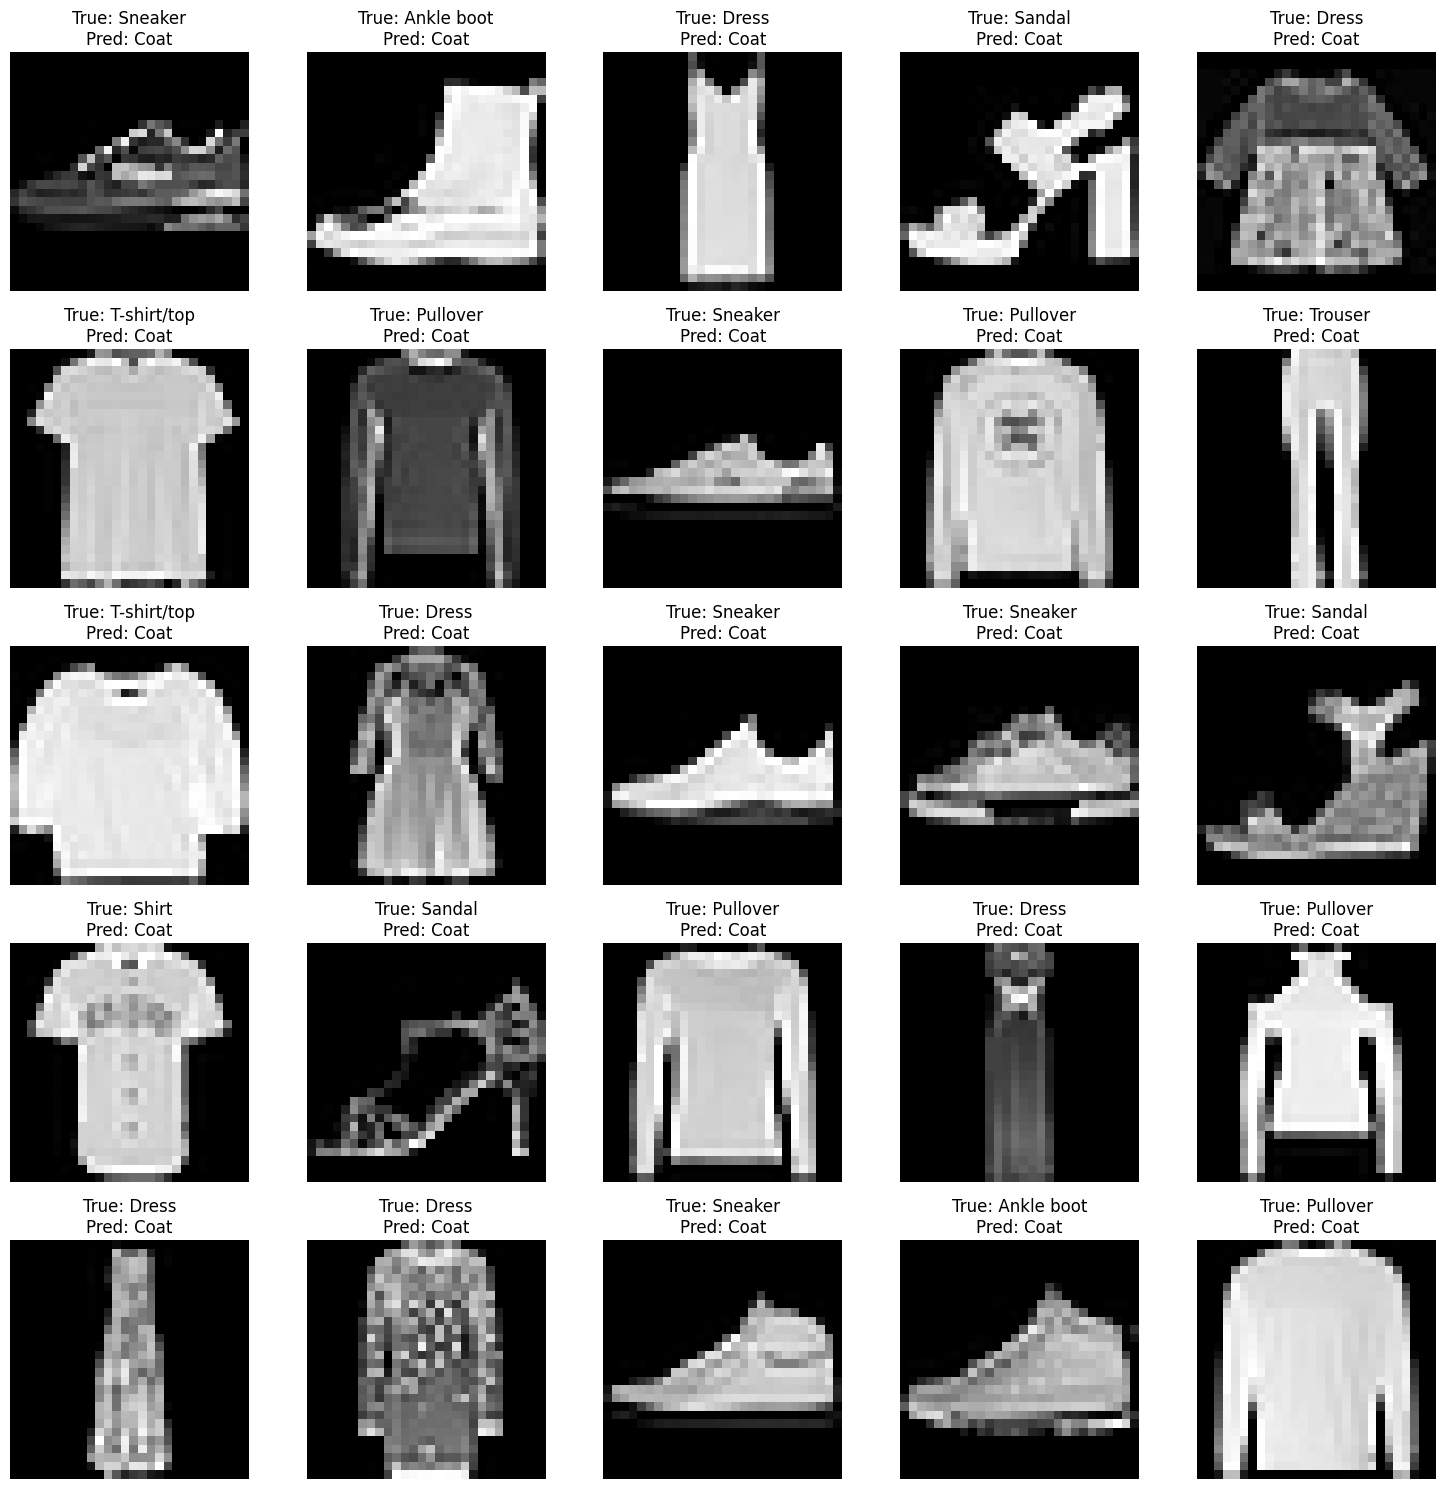

wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'hidden_layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'hidden_size' was locked by 'sweep' (ignored update).


In [1]:
# tille Q7
# import numpy as np
# import matplotlib.pyplot as plt
# from keras.datasets import fashion_mnist
# import wandb
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# Keep all the existing code from the provided script, and add the following at the end
# import numpy as np
# from keras.datasets import fashion_mnist
# import wandb
# import json
# import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json  # Add this for the previous error

# Define the sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init': {'values': ['random', 'xavier']},
        'weight_decay': {"values": [0, 0.0005, 0.5]}
    },
    "run_cap": 3
}

# Load and preprocess the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
num_classes = 10

# One-hot encode the labels
def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

y_train, y_test = one_hot_encode(y_train, num_classes), one_hot_encode(y_test, num_classes)

# Split training data into train and validation sets
split_idx = int(0.9 * len(x_train))
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]

# Activation Functions
def relu(Z):
    return np.maximum(0, Z)

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

activation_functions = {"relu": relu, "sigmoid": sigmoid, "tanh": tanh}

# Optimizer functions
def sgd(weights, biases, grads_W, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_W[i]
        biases[i] -= learning_rate * grads_b[i]
    return weights, biases

def momentum(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        weights[i] += velocity_W[i]
        biases[i] += velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def nesterov(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, momentum=0.9):
    for i in range(len(weights)):
        # Compute lookahead position
        lookahead_W = weights[i] + momentum * velocity_W[i]
        lookahead_b = biases[i] + momentum * velocity_b[i]

        # Update velocity
        velocity_W[i] = momentum * velocity_W[i] - learning_rate * grads_W[i]
        velocity_b[i] = momentum * velocity_b[i] - learning_rate * grads_b[i]

        # Update weights and biases with corrected lookahead step
        weights[i] = lookahead_W + velocity_W[i]
        biases[i] = lookahead_b + velocity_b[i]
    return weights, biases, velocity_W, velocity_b

def rmsprop(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, beta=0.9, epsilon=1e-6):
    for i in range(len(weights)):
        # Update velocity for weights and biases separately
        velocity_W[i] = beta * velocity_W[i] + (1 - beta) * (grads_W[i] ** 2)
        velocity_b[i] = beta * velocity_b[i] + (1 - beta) * (grads_b[i] ** 2)

        # Update weights
        weights[i] -= learning_rate * grads_W[i] / (np.sqrt(velocity_W[i]) + epsilon)

        # Update biases
        biases[i] -= learning_rate * grads_b[i] / (np.sqrt(velocity_b[i]) + epsilon)
    return weights, biases, velocity_W, velocity_b

def adam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = velocity_W[i] / (1 - beta1 ** t)
        velocity_b_corrected = velocity_b[i] / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Check and correct shape mismatch
        if moment2_b_corrected.shape != biases[i].shape:
            print(f"Shape mismatch at layer {i}: {moment2_b_corrected.shape} vs {biases[i].shape}")
            moment2_b_corrected = np.reshape(moment2_b_corrected, biases[i].shape)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

def nadam(weights, biases, grads_W, grads_b, learning_rate, velocity_W, velocity_b, moment2_W, moment2_b, t, beta1=0.9, beta2=0.999, epsilon=1e-6):
    for i in range(len(weights)):
        # First moment estimate
        velocity_W[i] = beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]
        velocity_b[i] = beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]

        # Second moment estimate
        moment2_W[i] = beta2 * moment2_W[i] + (1 - beta2) * (grads_W[i] ** 2)
        moment2_b[i] = beta2 * moment2_b[i] + (1 - beta2) * (grads_b[i] ** 2)

        # Bias correction
        velocity_W_corrected = (beta1 * velocity_W[i] + (1 - beta1) * grads_W[i]) / (1 - beta1 ** t)
        velocity_b_corrected = (beta1 * velocity_b[i] + (1 - beta1) * grads_b[i]) / (1 - beta1 ** t)

        moment2_W_corrected = moment2_W[i] / (1 - beta2 ** t)
        moment2_b_corrected = moment2_b[i] / (1 - beta2 ** t)

        # Parameter update
        weights[i] -= learning_rate * velocity_W_corrected / (np.sqrt(moment2_W_corrected) + epsilon)
        biases[i] -= learning_rate * velocity_b_corrected / (np.sqrt(moment2_b_corrected) + epsilon)
    
    return weights, biases, velocity_W, velocity_b, moment2_W, moment2_b

# Initialize network weights and biases
def init_weights(layers, method="random"):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
        else:  # Default to "random"
            limit = 0.1
        W = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        weights.append(W)
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# Forward pass
def forward(X, weights, biases, activation):
    A = [X]
    for i in range(len(weights) - 1):
        Z = A[-1] @ weights[i] + biases[i]
        A.append(activation_functions[activation](Z))
    Z = A[-1] @ weights[-1] + biases[-1]
    A.append(softmax(Z))
    return A

# Compute loss
def compute_loss(y_true, y_pred, weights, weight_decay):
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    loss += (weight_decay / 2) * sum(np.sum(W**2) for W in weights)
    return loss

# Backward pass
def backward(X, y, A, weights, weight_decay, activation):
    grads_W, grads_b = [], []
    dA = A[-1] - y
    
    for i in reversed(range(len(weights))):
        dW = A[i].T @ dA / X.shape[0]
        db = np.sum(dA, axis=0, keepdims=True) / X.shape[0]
        dW += weight_decay * weights[i]
        grads_W.append(dW)
        grads_b.append(db)
        
        if i > 0:
            if activation == "relu":
                dA = (dA @ weights[i].T) * (A[i] > 0)
            elif activation == "sigmoid":
                dA = (dA @ weights[i].T) * (A[i] * (1 - A[i]))
            elif activation == "tanh":
                dA = (dA @ weights[i].T) * (1 - A[i]**2)
    
    return grads_W[::-1], grads_b[::-1]


# Function to evaluate a model on test data
def evaluate_best_model(weights, biases, X_test, y_test, activation):
    # Forward pass
    A = forward(X_test, weights, biases, activation)
    y_pred = A[-1]
    
    # Calculate accuracy
    test_acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
    
    # Get predicted class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    return test_acc, cm, y_pred_labels, y_true_labels

# Function to plot confusion matrix with enhanced visualization
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap with a custom colormap
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
    
    # Improve aesthetics
    plt.title('Confusion Matrix for Fashion MNIST Classification', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    # Save the confusion matrix
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    
    # Log to wandb
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    
    plt.show()

# Function to create interactive visualizations of misclassified examples
def plot_misclassifications(X_test, y_true, y_pred, class_names):
    # Find misclassified examples
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) > 0:
        # Select a subset of misclassified examples
        sample_size = min(25, len(misclassified_indices))
        sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
        
        # Create a grid to display the images
        fig, axes = plt.subplots(5, 5, figsize=(15, 15))
        axes = axes.flatten()
        
        # Original shape of each image
        img_size = int(np.sqrt(X_test.shape[1]))
        
        for i, idx in enumerate(sample_indices):
            if i < 25:  # Ensure we don't go out of bounds
                # Reshape the flattened image back to 2D
                img = X_test[idx].reshape(img_size, img_size)
                
                # Display the image
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
                axes[i].axis('off')
        
        # Remove empty subplots
        for i in range(sample_size, 25):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.savefig('misclassified_examples.png')
        
        # Log to wandb
        wandb.log({"misclassified_examples": wandb.Image(plt)})
        
        plt.show()

# Replace the train_model function to save the best model
def train_model():
    # Initialize wandb for this run
    wandb.init(project="assignment_1", entity="da24m015-iitm")
    config = wandb.config
    wandb.run.name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    
    # Create network architecture based on config
    architecture = [784] + [config.hidden_size] * config.hidden_layers + [10]
    
    # Initialize weights and biases
    weights, biases = init_weights(architecture, config.weight_init)
    
    # Initialize optimizer-specific parameters
    velocity_W = [np.zeros_like(W) for W in weights]
    velocity_b = [np.zeros_like(b) for b in biases]
    moment2_W = [np.zeros_like(W) for W in weights]
    moment2_b = [np.zeros_like(b) for b in biases]
    t = 1  # Timestep for Adam/Nadam
    
    num_samples = x_train.shape[0]
    
    best_val_acc = 0
    best_weights = None
    best_biases = None
    
    for epoch in range(config.epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled, y_train_shuffled = x_train[indices], y_train[indices]
        
        total_loss, total_acc = 0, 0
        num_batches = num_samples // config.batch_size
        
        for i in range(0, num_samples, config.batch_size):
            X_batch = X_train_shuffled[i:i + config.batch_size]
            y_batch = y_train_shuffled[i:i + config.batch_size]
            
            # Forward Pass
            A = forward(X_batch, weights, biases, config.activation)
            y_pred = A[-1]
            
            # Compute Loss & Accuracy
            loss = compute_loss(y_batch, y_pred, weights, config.weight_decay)
            acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
            
            total_loss += loss * len(X_batch)
            total_acc += acc * len(X_batch)
            
            # Backward Pass
            grads_W, grads_b = backward(X_batch, y_batch, A, weights, config.weight_decay, config.activation)
            
            # Update Weights using the selected optimizer
            if config.optimizer == "sgd":
                weights, biases = sgd(weights, biases, grads_W, grads_b, config.learning_rate)
            elif config.optimizer == "momentum":
                weights, biases, velocity_W, velocity_b = momentum(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "nesterov":
                weights, biases, velocity_W, velocity_b = nesterov(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "rmsprop":
                weights, biases, velocity_W, velocity_b = rmsprop(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b)
            elif config.optimizer == "adam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = adam(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t)
                t += 1
            elif config.optimizer == "nadam":
                weights, biases, velocity_W, velocity_b, moment2_W, moment2_b = nadam(
                    weights, biases, grads_W, grads_b, config.learning_rate, velocity_W, velocity_b, 
                    moment2_W, moment2_b, t)
                t += 1
        
        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / num_samples
        avg_acc = total_acc / num_samples
        
        # Validation Metrics
        val_A = forward(x_val, weights, biases, config.activation)
        val_pred = val_A[-1]
        val_loss = compute_loss(y_val, val_pred, weights, config.weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1))
        
        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1, 
            "loss": avg_loss, 
            "accuracy": avg_acc,
            "val_loss": val_loss, 
            "val_accuracy": val_acc
        })
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = [w.copy() for w in weights]
            best_biases = [b.copy() for b in biases]
    
    # Save the best model parameters to wandb
    model_artifact = wandb.Artifact('best_model', type='model')
    
    # Save the best model configuration for later retrieval
    best_config = {
        "architecture": architecture,
        "activation": config.activation,
        "optimizer": config.optimizer,
        "learning_rate": config.learning_rate,
        "batch_size": config.batch_size,
        "weight_decay": config.weight_decay,
        "weight_init": config.weight_init,
        "hidden_layers": config.hidden_layers,
        "hidden_size": config.hidden_size,
        "val_accuracy": best_val_acc
    }
    
    # Save best model config as JSON
    import json
    with open('best_model_config.json', 'w') as f:
        json.dump(best_config, f)
    
    model_artifact.add_file('best_model_config.json')
    
    # Save best weights and biases as numpy arrays
    for i, (w, b) in enumerate(zip(best_weights, best_biases)):
        np.save(f'best_weights_{i}.npy', w)
        np.save(f'best_biases_{i}.npy', b)
        model_artifact.add_file(f'best_weights_{i}.npy')
        model_artifact.add_file(f'best_biases_{i}.npy')
    
    wandb.log_artifact(model_artifact)
    
    return best_weights, best_biases, best_config

# Function to evaluate and analyze the best model after sweeps
def analyze_best_model(api=None):
    if api is None:
        api = wandb.Api()
    
    # Start a new wandb run for evaluation
    wandb.init(project="assignment_1", entity="da24m015-iitm", name="best_model_evaluation")
    
    # Get all runs from the sweep
    runs = api.runs("da24m015-iitm/assignment_1")
    
    # Find the run with the highest validation accuracy
    best_run = None
    best_val_acc = 0
    
    for run in runs:
        if run.state == "finished":
            # Get the best validation accuracy from the run
            val_acc = run.summary.get("val_accuracy", 0)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_run = run
    
    if best_run:
        print(f"Best run: {best_run.name} with validation accuracy: {best_val_acc:.4f}")
        
        # Download the best model artifact
        artifact = api.artifact(f"da24m015-iitm/assignment_1/best_model:latest")
        artifact_dir = artifact.download()
        
        # Load model configuration
        with open(f"{artifact_dir}/best_model_config.json", "r") as f:
            config = json.load(f)
        
        # Load weights and biases
        architecture = config["architecture"]
        weights = []
        biases = []
        
        for i in range(len(architecture) - 1):
            weights.append(np.load(f"{artifact_dir}/best_weights_{i}.npy"))
            biases.append(np.load(f"{artifact_dir}/best_biases_{i}.npy"))
        
        # Evaluate on the test set
        test_acc, cm, y_pred, y_true = evaluate_best_model(
            weights, biases, x_test, y_test, config["activation"]
        )
        
        print(f"Test accuracy: {test_acc:.4f}")
        
        # Class names for Fashion MNIST
        class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, class_names)
        
        # Plot misclassified examples
        plot_misclassifications(x_test, y_true, y_pred, class_names)
        
        # Log the best model configuration
        wandb.config.update(config)
        
        # Log test accuracy
        wandb.log({"test_accuracy": test_acc})
        
        return weights, biases, config
    else:
        print("No completed runs found.")
        return None, None, None

# Main execution for evaluation after sweeps complete
if __name__ == "__main__":
    # First run the sweep as before
    sweep_id = wandb.sweep(sweep_config, project="assignment_1")
    wandb.agent(sweep_id, function=train_model)
    
    # After the sweep completes, analyze the best model
    api = wandb.Api()
    analyze_best_model(api)

In [3]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Initialize wandb sweep configuration
sweep_config = {
    'method': 'grid',  # Try different values systematically
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [0.1, 0.01, 0.001]},
        'batch_size': {'values': [16, 32, 64]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam']},
        'num_hidden_layers': {'values': [2, 3, 4]},
        'activation': {'values': ['relu', 'tanh']},
    }
}
sweep_id = wandb.sweep(sweep_config, project="assignment 1")

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_functions, weight_init="random"):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.num_layers = len(hidden_layers) + 1  # Hidden + Output layer
        
        self.activation_map = {
            'sigmoid': self.sigmoid,
            'tanh': self.tanh,
            'relu': self.relu,
            'softmax': self.softmax
        }
        
        self.activation_functions = [self.activation_map[fn.lower()] for fn in activation_functions]
        self.activation_derivatives = [
            self.sigmoid_derivative if fn == 'sigmoid' else
            self.tanh_derivative if fn == 'tanh' else
            self.relu_derivative if fn == 'relu' else None
            for fn in activation_functions[:-1]
        ]
        
        self.parameters = self._initialize_parameters(weight_init)
    
    def _initialize_parameters(self, weight_init):
        parameters = {}
        layer_dims = [self.input_size] + self.hidden_layers + [self.output_size]
        
        for l in range(1, len(layer_dims)):
            if weight_init == "random":
                parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            elif weight_init == "xavier":
                parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1. / layer_dims[l-1])
            parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
        
        return parameters

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def sigmoid_derivative(self, A):
        return A * (1 - A)
    
    def tanh(self, Z):
        return np.tanh(Z)
    
    def tanh_derivative(self, A):
        return 1 - np.square(A)
    
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, A):
        return (A > 0).astype(float)
    
    def softmax(self, Z):
        exps = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def forward_propagation(self, X):
        A = X.T
        activations = [A]
        
        for l in range(1, self.num_layers):
            Z = np.dot(self.parameters[f'W{l}'], A) + self.parameters[f'b{l}']
            A = self.activation_functions[l - 1](Z)
            activations.append(A)
        
        Z_out = np.dot(self.parameters[f'W{self.num_layers}'], A) + self.parameters[f'b{self.num_layers}']
        A_out = self.softmax(Z_out)
        activations.append(A_out)
        
        return activations
    
    def predict(self, X):
        A_out = self.forward_propagation(X)[-1]
        return np.argmax(A_out, axis=0)

def train_model():
    wandb.init(project="assignment 1", config=sweep_config['parameters'])
    config = wandb.config
    
    # Load data
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = (X_train - np.mean(X_train)) / np.std(X_train), (X_test - np.mean(X_test)) / np.std(X_test)
    X_train_flat, X_test_flat = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
    
    # Create validation set
    val_size = int(X_train_flat.shape[0] * 0.1)
    X_val, y_val = X_train_flat[:val_size], y_train[:val_size]
    X_train_final, y_train_final = X_train_flat[val_size:], y_train[val_size:]
    
    # Configure model
    nn = NeuralNetwork(
        input_size=784,
        hidden_layers=[128] * config.num_hidden_layers,
        output_size=10,
        activation_functions=[config.activation] * config.num_hidden_layers + ['softmax'],
        weight_init="xavier"
    )
    
    # Training loop (dummy implementation for now)
    for epoch in range(5):  # Use 5 epochs as an example
        loss = np.random.rand()  # Placeholder for actual loss computation
        val_accuracy = np.random.rand()  # Placeholder for validation accuracy
        
        wandb.log({"epoch": epoch, "loss": loss, "val_accuracy": val_accuracy})
    
    wandb.finish()

wandb.agent(sweep_id, train_model)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001D3E4A18F40>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1d3843a9780, raw_cell="import numpy as np
import wandb
from keras.dataset.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Rajnish/Desktop/Rajnish/M.Tech%20DSAI%2726/M.Tech%20DSAI%202024-2026/Semester%202/Introduction%20to%20Deep%20Learning/Introduction-to-Deep-Learning-DA6401-/Assignment%201/sample.ipynb#W1sZmlsZQ%3D%3D>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: tm8mv88i
Sweep URL: https://wandb.ai/da24m015-iitm/assignment%201/sweeps/tm8mv88i


wandb: Agent Starting Run: 9nl8dfd1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.1
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: sgd


Exception in thread Thread-93 (_run_job):
Traceback (most recent call last):
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Rajnish\AppData\Local\Temp\ipykernel_16696\4041631253.py", line 99, in train_model
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1485, in init
    wandb._sentry.reraise(e)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\analytics\sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 1471, in init
    return wi.init(run_settings, run_config)
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wandb\sdk\wandb_init.py", line 779, in init
    with telemetry.context() as tel:
  File "c:\Users\Rajnish\anaconda3\envs\keras_env\lib\site-packages\wand

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001D3E4A18F40>> (for post_run_cell), with arguments args (<ExecutionResult object at 1d3843a96c0, execution_count=3 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1d3843a9780, raw_cell="import numpy as np
import wandb
from keras.dataset.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Rajnish/Desktop/Rajnish/M.Tech%20DSAI%2726/M.Tech%20DSAI%202024-2026/Semester%202/Introduction%20to%20Deep%20Learning/Introduction-to-Deep-Learning-DA6401-/Assignment%201/sample.ipynb#W1sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine